# Exercise 2: Locality-sensitive Hashing

## Kyrylo Kolesnichenko

## 153371848

#### Task 2.1

**Compute the minhash signature for each column using the following hash functions:**
- ℎ1(𝑥) = 2𝑥 + 1 𝑚𝑜𝑑 6
- ℎ2(𝑥) = 3𝑥 + 2 𝑚𝑜𝑑 6
- ℎ3(𝑥) = 5𝑥 + 2 𝑚𝑜𝑑 6 

In [11]:
import pandas as pd

# Initializing the matrix
matrix_data = {
    'S1': [1, 0, 0, 1, 0, 0],
    'S2': [1, 1, 0, 0, 1, 0],
    'S3': [0, 0, 0, 1, 1, 1],
    'S4': [1, 0, 1, 0, 1, 0]
}
df = pd.DataFrame(matrix_data, index=[0, 1, 2, 3, 4, 5])

# Defining the hash functiosns
def h1(x): return (2 * x + 1) % 6
def h2(x): return (3 * x + 2) % 6
def h3(x): return (5 * x + 2) % 6

# Applying the functions
hash_df = pd.DataFrame({
    'h1': [h1(x) for x in df.index],
    'h2': [h2(x) for x in df.index],
    'h3': [h3(x) for x in df.index]
}, index=df.index)

# Finding the signature matrix
signature = pd.DataFrame(index=['h1', 'h2', 'h3'], columns=df.columns)

for col in df.columns:
    for h in signature.index:
        relevant_rows = df[df[col] == 1].index
        signature.loc[h, col] = hash_df.loc[relevant_rows, h].min()

print(signature)

   S1 S2 S3 S4
h1  1  1  1  1
h2  2  2  2  2
h3  2  1  3  0


The task asked us to make the Minhash signature matrix using three different hash functions. So first, we initializing data and defining functions. After their we applied them, we got 3×4 signature matrix that compactly represents original data without using the full matrix.

**Which of these hash functions are true permutations?**

In order to check which of the hash functions are true permutations, we need to apply each function to all integers from 0 to 5. If the output has all numbers from 0 to 5 without duplicates, then the function will be a true permutation.

In [12]:
domain = list(range(6))

h1_values = [(2 * x + 1) % 6 for x in domain]
h2_values = [(3 * x + 2) % 6 for x in domain]
h3_values = [(5 * x + 2) % 6 for x in domain]

print("h1:", h1_values)
print("h2:", h2_values)
print("h3:", h3_values)

h1: [1, 3, 5, 1, 3, 5]
h2: [2, 5, 2, 5, 2, 5]
h3: [2, 1, 0, 5, 4, 3]


From the result we see that only h3 has all the numbers meaning that it is the only true permutations

**How close are the estimated Jaccard similarities for the six pairs of columns to the true Jaccard
similarities?**

To compare the similarities, we need to calculate the true Jaccard similarities between pairs of columns from the original matrix and to estimate them from the signature matrix. The true similarity will be the intersection over the union of 1’s in each pair, and estimated one will be the number of matching values in the signature divided by the total number of hash functions.

In [13]:
# The True Jaccard similarities
true_jaccard = {}

cols = list(df.columns)

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        col1 = df[cols[i]]
        col2 = df[cols[j]]

        a_ones = set(col1[col1 == 1].index)
        b_ones = set(col2[col2 == 1].index)

        intersection = len(a_ones & b_ones)
        union = len(a_ones | b_ones)

        pair = (cols[i], cols[j])
        true_jaccard[pair] = intersection / union

# The Estimated Jaccard similarities
est_jaccard = {}

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        col1 = signature[cols[i]]
        col2 = signature[cols[j]]

        match_count = sum(col1[k] == col2[k] for k in signature.index)

        pair = (cols[i], cols[j])
        est_jaccard[pair] = match_count / len(signature)

print("True Jaccard Similarities:")
for pair in true_jaccard:
    print(f"{pair}: {true_jaccard[pair]:.2f}")

print("\nEstimated Jaccard Similarities:")
for pair in est_jaccard:
    print(f"{pair}: {est_jaccard[pair]:.2f}")

True Jaccard Similarities:
('S1', 'S2'): 0.25
('S1', 'S3'): 0.25
('S1', 'S4'): 0.25
('S2', 'S3'): 0.20
('S2', 'S4'): 0.50
('S3', 'S4'): 0.20

Estimated Jaccard Similarities:
('S1', 'S2'): 0.67
('S1', 'S3'): 0.67
('S1', 'S4'): 0.67
('S2', 'S3'): 0.67
('S2', 'S4'): 0.67
('S3', 'S4'): 0.67


As the result, we got the true similarities in range from 0.20 to 0.50, while all estimated values are 0.67. This shows that with only 3 hash functions, the estimates are not accurate and, in our case, to overestimate the actual value.

**Consider the S-curve of equation: 1 − (1 − 𝑠𝑟)𝑏**

**Evaluate the curve for the following values of 𝑟 and 𝑏:**
- 𝑟 = 3 and 𝑏 = 10
 - 𝑟 = 7 and 𝑏 = 20
  - 𝑟 = 5 and 𝑏 = 40

  Plot the results to your report.
  
**For each of the above pairs find the value of Jaccard similarity for which the probability of becoming**
**a candidate is 0,5. How close is this to the estimate of (1𝑏 ⁄ )1𝑟 ⁄?**

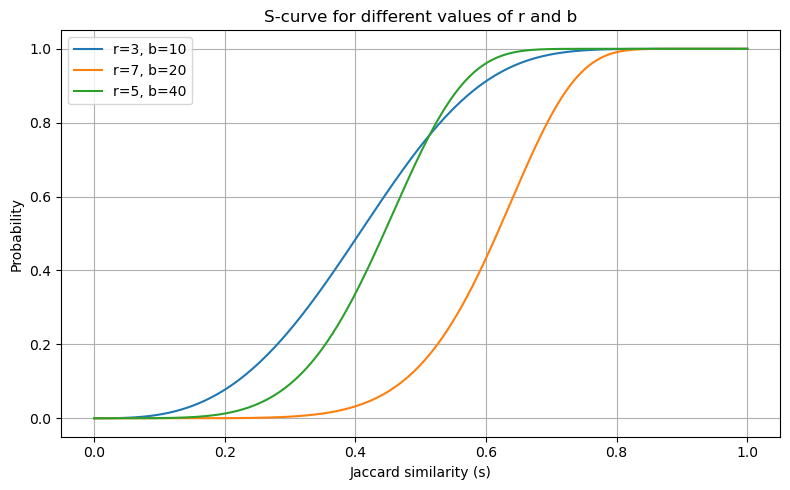

r=3, b=10 | actual: 0.4060 | estimate: 0.4642
r=7, b=20 | actual: 0.6171 | estimate: 0.6518
r=5, b=40 | actual: 0.4436 | estimate: 0.4782


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def s_curve(s, r, b):
    return 1 - (1 - s**r)**b

s = np.linspace(0, 1, 500)

params = [(3, 10), (7, 20), (5, 40)]

plt.figure(figsize=(8, 5))

for r, b in params:
    p = s_curve(s, r, b)
    plt.plot(s, p, label=f"r={r}, b={b}")

plt.title("S-curve for different values of r and b")
plt.xlabel("Jaccard similarity (s)")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



def find_threshold(r, b):
    s_vals = np.linspace(0, 1, 10000)
    probs = 1 - (1 - s_vals**r)**b
    closest_index = np.argmin(np.abs(probs - 0.5))
    return s_vals[closest_index]

for r, b in params:
    actual = find_threshold(r, b)
    estimate = (1 / b)**(1 / r)
    print(f"r={r}, b={b} | actual: {actual:.4f} | estimate: {estimate:.4f}")

After evaluating and plotting the values using the equation, we found the similarity values where the probability reaches 0.5 and compared them to the estimated thresholds. The actual values were slightly lower but still close, which means the estimate gives a reasonable approximation.

#### 2.3.1 Shingling

The code below generates ngrams of input text files. It removes spaces and all non-letter characters
(preserving only letters a-z) and then generates ngrams by shingling.

**Test the code with different shingle length values. Include first rows of the test results in your report (do not copy the whole result!).
Based on the course material, how does shingle length affect similarity analysis?**


In [15]:
import pyspark
import re
sc = pyspark.SparkContext("local", "Similarity")

def make_shingles(text, shingle_len):
    text = text.lower()
    text = re.sub(r'[^a-z]+', '', text)
    for i in range(0, len(text) - shingle_len - 1):
        yield text[i:i + shingle_len]

shingle_lengths = [3, 5, 7]
files = sc.wholeTextFiles('*.txt')

for sh_len in shingle_lengths:
    shingles = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles(p[1], sh_len)))).collect()
    print(f"\nShingle length: {sh_len}")
    for file, sh in shingles:
        print(f"{file}: {sh[:5]}")


Shingle length: 3
bank.txt: ['aba', 'ban', 'ank', 'nki', 'kis']
cat.txt: ['thi', 'his', 'isa', 'sar', 'art']
catfood.txt: ['cat', 'atf', 'tfo', 'foo', 'ood']
hadoop.txt: ['apa', 'pac', 'ach', 'che', 'heh']
hares.txt: ['har', 'are', 'res', 'esa', 'san']
lsh.txt: ['loc', 'oca', 'cal', 'ali', 'lit']
mapreduce.txt: ['map', 'apr', 'pre', 'red', 'edu']
minhash.txt: ['inc', 'nco', 'com', 'omp', 'mpu']
rabbit.txt: ['rab', 'abb', 'bbi', 'bit', 'itb']
setsim.txt: ['set', 'ets', 'tsi', 'sim', 'imi']
swissbank.txt: ['ban', 'ank', 'nki', 'kin', 'ing']
tortoise.txt: ['tor', 'ort', 'rto', 'toi', 'ois']
turtles.txt: ['tur', 'urt', 'rtl', 'tle', 'les']
universal_hash.txt: ['uni', 'niv', 'ive', 'ver', 'ers']

Shingle length: 5
bank.txt: ['abank', 'banki', 'ankis', 'nkisa', 'kisaf']
cat.txt: ['thisa', 'hisar', 'isart', 'sarti', 'artic']
catfood.txt: ['catfo', 'atfoo', 'tfood', 'foodf', 'oodfo']
hadoop.txt: ['apach', 'pache', 'acheh', 'cheha', 'hehad']
hares.txt: ['hares', 'aresa', 'resan', 'esand', 'san

The code above applies different shingle lengths and outputs sample of the result. 

As shingle length increases, the number of shingles decreases and each one carries more context, which affects how document similarity is measured.

**Sometimes it is useful to preserve white spaces in shingles. You can preserve white spaces (the \s
character) by using the condition [^a-z]\s+ in the argument of the re.sub function. Test this and
include first rows of the result in your report.**

In [16]:
import pyspark
import re


def make_shingles(text, shingle_len):
    text = text.lower()
    text = re.sub(r'[^a-z\s]+', '', text)
    for i in range(0, len(text) - shingle_len - 1):
        yield text[i:i + shingle_len]

shingle_length = 6
files = sc.wholeTextFiles('*.txt')
files = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles(p[1], shingle_length))))
res = files.collect()

for file, shingles in res:
    print(f"{file}: {shingles[:5]}")

bank.txt: ['a bank', ' bank ', 'bank i', 'ank is', 'nk is ']
cat.txt: ['this a', 'his ar', 'is art', 's arti', ' artic']
catfood.txt: ['cat fo', 'at foo', 't food', ' food\r', 'food\r\n']
hadoop.txt: ['apache', 'pache ', 'ache h', 'che ha', 'he had']
hares.txt: ['hares ', 'ares a', 'res an', 'es and', 's and ']
lsh.txt: ['locali', 'ocalit', 'cality', 'alitys', 'lityse']
mapreduce.txt: ['mapred', 'apredu', 'preduc', 'reduce', 'educe ']
minhash.txt: ['in com', 'n comp', ' compu', 'comput', 'ompute']
rabbit.txt: ['rabbit', 'abbit\r', 'bbit\r\n', 'bit\r\nb', 'it\r\nbu']
setsim.txt: ['set si', 'et sim', 't simi', ' simil', 'simila']
swissbank.txt: ['bankin', 'anking', 'nking ', 'king i', 'ing in']
tortoise.txt: ['tortoi', 'ortois', 'rtoise', 'toises', 'oises ']
turtles.txt: ['turtle', 'urtles', 'rtles ', 'tles a', 'les ar']
universal_hash.txt: ['univer', 'nivers', 'iversa', 'versal', 'ersal ']


Now, the output includes spaces in the shingles, it can help capture word boundaries and possibly improve accuracy when text structure matters.

#### 2.3.2 Calculating hashes

**Modify the make_shingles function to produce hashes by replacing the last line of the function by:**

yield string_hash(text[i:i+shingle_len],shingle_len, Ashingle, Pshingle)

**Add then the following code before the make_shingles function definition:**



In [17]:
from numpy import uint32
from numpy import uint64
import random
import numpy

def generate_random_hash_params_A_P():
    A = random.getrandbits(64)
    P = random.getrandbits(64)
    while A >= P:
        A = random.getrandbits(64)
        P = random.getrandbits(64)
    return A, P

Ashingle, Pshingle = generate_random_hash_params_A_P()

def string_hash(shingle, slen, A, P):
    tmp = uint64(ord(shingle[0]))
    for i in range(1, slen):
        tmp = (tmp * uint64(A) + uint64(ord(shingle[i]))) % uint64(P)
    return uint32(tmp & uint64(0xFFFFFFFF))

def make_shingles(text, shingle_len):
    text = text.lower()
    text = re.sub(r'[^a-z]+', '', text)
    for i in range(0, len(text) - shingle_len - 1):
        yield string_hash(text[i:i + shingle_len], shingle_len, Ashingle, Pshingle)

shingle_length = 6
files = sc.wholeTextFiles('*.txt')
files = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles(p[1], shingle_length))))
res = files.collect()

for file, shingles in res:
    print(f"{file}: {shingles[:5]}")

/var/folders/n0/dbh6l6zn6rqdmcf6lg166bbr0000gn/T/ipykernel_61606/163472127.py:19: RuntimeWarning: overflow encountered in scalar multiply


bank.txt: [4055704653, 1882341974, 2303259273, 71639820, 284115183]
cat.txt: [417108014, 3942722465, 787163600, 3405095370, 3458561568]
catfood.txt: [720915536, 1473210769, 2387769299, 977271702, 3011444005]
hadoop.txt: [2964990062, 2742337369, 811058056, 1373068187, 4278119713]
hares.txt: [2603708458, 1363638076, 1709178535, 2843141728, 2646242684]
lsh.txt: [2964021838, 3319524186, 1045280368, 639708544, 459611684]
mapreduce.txt: [1354198772, 3976670275, 268453551, 3090392679, 4270293249]
minhash.txt: [419640674, 2500774568, 547820958, 713934436, 2447683887]
rabbit.txt: [953949290, 3308974886, 2119752671, 197960477, 2757839918]
setsim.txt: [2611138389, 1719316657, 1901372646, 1983682599, 1612472409]
swissbank.txt: [1882341969, 3148280420, 1566070020, 1294646140, 3741111836]
tortoise.txt: [3175688743, 3816441192, 2912441966, 1182118643, 3788168650]
turtles.txt: [4095066204, 1839760483, 3753170169, 1189272040, 3816543050]
universal_hash.txt: [4241115459, 2198701834, 941812056, 311124730

**Run the code. What do you get as an output?**

As the result, I got hashed shingles in the form of 32-bit integers for each file, instead of string-based shingles.

**In what case does hashing compress the data?**

Hashing compresses the data when we replace longer character shingles with fixed-size integers, it makes storage and comparison more efficient, especially when the number of shingles is large. In our case, each shingle is a 6-character string, and hashing it into a single 32-bit integer definitely reduces memory usage

#### 2.3.3 MinHashing

In [18]:
def uint32_hash(stringhashes, A):
    for i in range(len(stringhashes)):
        stringhashes[i] = uint32((uint64(A) * uint64(stringhashes[i])) >> uint64(32))
    return stringhashes

def min_hash(hashes, minhash_A):
    minhashes = []
    for A in minhash_A:
        minhashes.append(min(uint32_hash(hashes.copy(), A)))
    return minhashes

num_minhashes = 15
minhash_A = [random.getrandbits(64) for _ in range(num_minhashes)]

minhashes = files.map(lambda p: (p[0], min_hash(p[1], minhash_A)))
minhashes.cache()

res = minhashes.collect()
for x in res:
    print(x)

/var/folders/n0/dbh6l6zn6rqdmcf6lg166bbr0000gn/T/ipykernel_61606/163472127.py:19: RuntimeWarning: overflow encountered in scalar multiply
/var/folders/n0/dbh6l6zn6rqdmcf6lg166bbr0000gn/T/ipykernel_61606/4268513630.py:3: RuntimeWarning: overflow encountered in scalar multiply


('bank.txt', [65987, 14692, 233815, 416869, 76543, 134996, 6235, 788223, 287, 97266, 1721, 190328, 200930, 658963, 224009])
('cat.txt', [71804, 179955, 255427, 290207, 108414, 54583, 5438, 149126, 80444, 65012, 176974, 190328, 32247, 215168, 84215])
('catfood.txt', [350852, 2011271, 77352, 516224, 312694, 134996, 45517, 967059, 1626633, 239603, 265535, 190328, 496342, 27159, 113884])
('hadoop.txt', [188964, 328311, 255427, 416869, 76543, 134996, 45517, 70242, 996920, 116836, 814233, 313475, 32247, 320113, 33864])
('hares.txt', [45023, 9433, 31847, 1121108, 1154401, 134996, 45517, 119346, 139669, 1142764, 1124005, 6383, 32247, 90572, 272307])
('lsh.txt', [3669841, 1934126, 1881987, 237571, 1154401, 134996, 45517, 1488114, 2472092, 590059, 250043, 364397, 42647, 248883, 184321])
('mapreduce.txt', [188964, 29563, 676430, 24349, 1110284, 649361, 45517, 119346, 417082, 579333, 522804, 190328, 538766, 219786, 184321])
('minhash.txt', [284324, 477833, 62159, 262238, 2794196, 2276083, 45517, 9

We get a list of 15 minhash values for each file. They capture the overall content of the files in more compact form and are going to be  used later to estimate similarity between documents without comparing all shingles directly.

#### 2.3.4 Jaccard similarity

**Test the code.**

In [ ]:
for x in res:
    jaccrow = minhashes.map(lambda p: (p[0],sum(numpy.array(p[1])-
numpy.array(x[1])==0)/num_minhashes)).collect()
    for y in jaccrow:
        print(x[0].ljust(20) + " vs. " + y[0].ljust(20) + " similarity: " + str(y[1]*100) + " %")

After running the code, we got the estimated Jaccard similarities between each pair of files. The values are based on how many of their minhash values match, and give an approximation of how similar the files are without comparing all shingles directly.

The output was too long, so I removed it and left the sample only

The sample of the output:

bank.txt             vs. bank.txt             similarity: 100.0 %

bank.txt             vs. cat.txt              similarity: 10.0 %

bank.txt             vs. catfood.txt          similarity: 2.0 %

bank.txt             vs. hadoop.txt           similarity: 6.0 %

bank.txt             vs. hares.txt            similarity: 10.0 %


**Run the code for the number of minhashes that correspond to error rates of 0.3, 0.2, 0.1, 0.05 (running the code for error rate 0.05 takes several minutes).**

In [ ]:
import numpy as np
import random

error_rates = [0.3, 0.2, 0.1, 0.05]
minhash_counts = [(1 / e) ** 2 for e in error_rates]
minhash_counts = [int(n) for n in minhash_counts]

for count in minhash_counts:
    print(f"\nRunning with {count} minhashes")
    
    A_list = [random.getrandbits(64) for _ in range(count)]

    def uint32_hash(hashes, A):
        for i in range(len(hashes)):
            hashes[i] = uint32((uint64(A) * uint64(hashes[i])) >> uint64(32))
        return hashes

    def min_hash(hashes, A_list):
        return [min(uint32_hash(hashes.copy(), A)) for A in A_list]

    minhashes = files.map(lambda p: (p[0], min_hash(p[1], A_list)))
    minhashes.cache()
    res = minhashes.collect()

    for x in res:
        jaccrow = minhashes.map(
            lambda p: (p[0], sum(np.array(p[1]) == np.array(x[1])) / count)
        ).collect()
        for y in jaccrow:
            print(x[0].ljust(20) + " vs. " + y[0].ljust(20) + " similarity: " + str(round(y[1] * 100, 2)) + " %")

Now calculating the number of minhashes needed for different error rates by the formula, and ran the similarity estimation for each case. 

I deleted the output cells since the output is too big

**What is the number of minhashesrequires for these error rates?**

For error rate 0.3 we need 11 minhashes, for 0.2 it’s 25, for 0.1 it’s 100, and for 0.05 it’s 400.

**How do the similarities change?**

When the number of minhashes increases, the similarity estimates become more stable and accurate. So, with higher counts the values better represent actual similarity between files.


**Selected 5 pairs and their similarities for error rate 0.3 (11 minhashes)**

bank.txt vs. bank.txt      → 100.0 %
bank.txt vs. cat.txt       → 0.0 %
bank.txt vs. catfood.txt   → 0.0 %
bank.txt vs. hadoop.txt    → 0.0 %
bank.txt vs. hares.txt     → 9.09 %

**Select the number of minhashes as 50. Run the code with two different shingle lengths and either
containing white spaces or not (i.e., 4 cases in total).**
 
**Report the similarities for the selected 5 pairs of documents.**

In [27]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

shingle_lengths = [5, 7]
preserve_spaces = [False, True]
num_minhashes = 50

def generate_random_hash_params_A_P():
    A = random.getrandbits(64)
    P = random.getrandbits(64)
    while A >= P:
        A = random.getrandbits(64)
        P = random.getrandbits(64)
    return A, P

def string_hash(shingle, slen, A, P):
    tmp = uint64(ord(shingle[0]))
    for i in range(1, slen):
        tmp = (tmp * uint64(A) + uint64(ord(shingle[i]))) % uint64(P)
    return uint32(tmp & uint64(0xFFFFFFFF))

def make_shingles(text, shingle_len, keep_spaces, A, P):
    text = text.lower()
    if keep_spaces:
        text = re.sub(r'[^a-z\s]+', '', text)
    else:
        text = re.sub(r'[^a-z]+', '', text)
    for i in range(0, len(text) - shingle_len - 1):
        yield string_hash(text[i:i + shingle_len], shingle_len, A, P)

def uint32_hash(hashes, A):
    for i in range(len(hashes)):
        hashes[i] = uint32((uint64(A) * uint64(hashes[i])) >> uint64(32))
    return hashes

def min_hash(hashes, A_list):
    return [min(uint32_hash(hashes.copy(), A)) for A in A_list]

for slen in shingle_lengths:
    for keep_ws in preserve_spaces:
        Ashingle, Pshingle = generate_random_hash_params_A_P()
        print(f"\nShingle length = {slen}, whitespace = {'yes' if keep_ws else 'no'}")

        files = sc.wholeTextFiles('*.txt')
        files = files.map(lambda p: (p[0].split("/")[-1], list(make_shingles(p[1], slen, keep_ws, Ashingle, Pshingle))))
        A_list = [random.getrandbits(64) for _ in range(num_minhashes)]
        minhashes = files.map(lambda p: (p[0], min_hash(p[1], A_list)))
        minhashes.cache()
        res = minhashes.collect()

        for x in res:
            jaccrow = minhashes.map(
                lambda p: (p[0], sum(np.array(p[1]) == np.array(x[1])) / num_minhashes)
            ).collect()

            for y in jaccrow:
                if (x[0], y[0]) in [
                    ("bank.txt", "cat.txt"),
                    ("bank.txt", "hares.txt"),
                    ("cat.txt", "mapreduce.txt"),
                    ("rabbit.txt", "tortoise.txt"),
                    ("swissbank.txt", "setsim.txt")
                ]:
                    print(x[0].ljust(20) + " vs. " + y[0].ljust(20) + " similarity: " + str(round(y[1] * 100, 2)) + " %")


Shingle length = 5, whitespace = no


/var/folders/n0/dbh6l6zn6rqdmcf6lg166bbr0000gn/T/ipykernel_61606/1828991683.py:19: RuntimeWarning: overflow encountered in scalar multiply
/var/folders/n0/dbh6l6zn6rqdmcf6lg166bbr0000gn/T/ipykernel_61606/1828991683.py:33: RuntimeWarning: overflow encountered in scalar multiply


bank.txt             vs. cat.txt              similarity: 18.0 %
bank.txt             vs. hares.txt            similarity: 16.0 %
cat.txt              vs. mapreduce.txt        similarity: 20.0 %
rabbit.txt           vs. tortoise.txt         similarity: 16.0 %
swissbank.txt        vs. setsim.txt           similarity: 6.0 %

Shingle length = 5, whitespace = yes


/var/folders/n0/dbh6l6zn6rqdmcf6lg166bbr0000gn/T/ipykernel_61606/1828991683.py:19: RuntimeWarning: overflow encountered in scalar multiply
/var/folders/n0/dbh6l6zn6rqdmcf6lg166bbr0000gn/T/ipykernel_61606/1828991683.py:33: RuntimeWarning: overflow encountered in scalar multiply


bank.txt             vs. cat.txt              similarity: 24.0 %
bank.txt             vs. hares.txt            similarity: 12.0 %
cat.txt              vs. mapreduce.txt        similarity: 14.0 %
rabbit.txt           vs. tortoise.txt         similarity: 14.0 %
swissbank.txt        vs. setsim.txt           similarity: 10.0 %

Shingle length = 7, whitespace = no


/var/folders/n0/dbh6l6zn6rqdmcf6lg166bbr0000gn/T/ipykernel_61606/1828991683.py:19: RuntimeWarning: overflow encountered in scalar multiply
/var/folders/n0/dbh6l6zn6rqdmcf6lg166bbr0000gn/T/ipykernel_61606/1828991683.py:33: RuntimeWarning: overflow encountered in scalar multiply


bank.txt             vs. cat.txt              similarity: 6.0 %
bank.txt             vs. hares.txt            similarity: 0.0 %
cat.txt              vs. mapreduce.txt        similarity: 8.0 %
rabbit.txt           vs. tortoise.txt         similarity: 2.0 %
swissbank.txt        vs. setsim.txt           similarity: 0.0 %

Shingle length = 7, whitespace = yes


/var/folders/n0/dbh6l6zn6rqdmcf6lg166bbr0000gn/T/ipykernel_61606/1828991683.py:19: RuntimeWarning: overflow encountered in scalar multiply
/var/folders/n0/dbh6l6zn6rqdmcf6lg166bbr0000gn/T/ipykernel_61606/1828991683.py:33: RuntimeWarning: overflow encountered in scalar multiply


bank.txt             vs. cat.txt              similarity: 10.0 %
bank.txt             vs. hares.txt            similarity: 10.0 %
cat.txt              vs. mapreduce.txt        similarity: 6.0 %
rabbit.txt           vs. tortoise.txt         similarity: 6.0 %
swissbank.txt        vs. setsim.txt           similarity: 0.0 %


Testing four configurations, using 50 minhashes with shingle lengths 5 and 7, both with and without whitespace.

Sorry for the warnings in the output, I didn’t find a way to remove them.

**Analyze the results for the two previous steps.**

So, with increases of the number of minhashes, the similarity estimates are getting more accurate. With very few hash functions, the estimates are noisy and unstable, while larger counts (like 100 or 400) give more reliable results.

Changing the shingle length and whitespace setting also affects similarity. Shorter shingles with whitespaces give higher similarity values, since they represent more small patterns. at the same time, making shingles longer or removing spaces makes the representation stricter, so the algorithm detects fewer overlaps, and as a result, the similarity result is lower.